In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from itertools import combinations
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import interpolate, stats

import seaborn as sns
import pandas as pd

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis
import sbibm

import swyft

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

In [3]:
def get_10k(x):
    return np.random.permutation(x)[:10000, ...]

In [4]:
log = logging.getLogger()
log.setLevel(logging.INFO)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [5]:
np.random.seed(27);
torch.manual_seed(27);

In [6]:
SAVE = False

In [7]:
TASK_NAME = "torus"
task = sbibm.get_task(
    TASK_NAME,
)

NUM_OBS = 1
NINIT = 5_000
N_POSTERIOR_SAMPLES = 50_000
MAX_ROUNDS = 10
SIMKEY = "x"
DEVICE = torch.device('cuda:0')

theta0 = task.get_true_parameters(NUM_OBS).squeeze()
obs0 = task.get_observation(NUM_OBS).squeeze()
print(theta0)
print(obs0)

tensor([0.5700, 0.8000, 1.0000])
tensor([0.5700, 0.0300, 1.0000])


# Apply swyft to the problem

### We will calculate the problem, and plot it.

_swyft_ needs a map from the hypercube to our physical parameters.

In [8]:
def swyftify_simulator(fn, x):
    xt = torch.from_numpy(x).float()
    y = fn(xt).squeeze().numpy()
    return {SIMKEY: y}

prior_transform = identity

def swyftify_theta(theta):
    return prior_transform(theta.clone().squeeze().float().numpy())

def swyftify_obs(obs):
    return {SIMKEY: obs.clone().squeeze().float().numpy()}

forward = partial(swyftify_simulator, task.get_simulator())
simulator = swyft.Simulator(
    forward,
    sim_shapes = {SIMKEY: (task.dim_data,)}
)
store = swyft.MemoryStore(task.dim_parameters, simulator = simulator)

prior = swyft.Prior.from_uv(prior_transform, task.dim_parameters)
theta0_swyft = swyftify_theta(theta0)
obs0_swyft = swyftify_obs(obs0)
print(obs0_swyft)

twod_marginals = list(combinations(range(task.dim_parameters), 2))
print(f"list of 2d marginals: {twod_marginals}")

{'x': array([0.57      , 0.03000003, 1.        ], dtype=float32)}
list of 2d marginals: [(0, 1), (0, 2), (1, 2)]


In [9]:
myhps = True
if myhps:
    train_args = dict(
        batch_size=256,
        validation_size=0.10,
        early_stopping_patience=20,
        max_epochs=300,
        lr=1e-2,
        reduce_lr_factor=0.1,
        reduce_lr_patience=5,
        nworkers=4,
        # optimizer_fn=partial(torch.optim.SGD, momentum=0.9)
    )
    tail_args = dict(
        # hidden_features=128 + 32,
        hidden_features=64,
        num_blocks=2,
        online_z_score_obs=True,
        online_z_score_par=True,
        # dropout_probability=0.0,
        # activation = F.relu,
        use_batch_norm=True,
    )
    head_args = {
        # 'obs_shapes': {'mu': torch.Size([3])}, 
        # 'obs_transform': None, 
        'online_norm': False,
    }
    get_tail = make_resenet_tail
else:
    train_args = {}
    tail_args = {}
    head_args = {}
    get_tail = swyft.DefaultTail

### swyft zoomin

In [10]:
if SAVE:
    micro = swyft.Microscope(
        [(i,) for i in range(task.dim_parameters)], 
        prior, 
        obs0_swyft,
        store = store, 
        device = DEVICE, 
        Ninit = NINIT,
        train_args = train_args,
        tail = get_tail,
        tail_args = tail_args,
        head_args = head_args,
    )
    micro.focus(max_rounds=MAX_ROUNDS)
    posterior = swyft.Posteriors.from_Microscope(micro)

    for posterior in micro.posteriors:
        posterior.infer(
            twod_marginals,
            device=DEVICE,
            train_args=train_args,
            tail=get_tail,
            tail_args=tail_args,
            head_args=head_args,
        )

    focused_samples = [p.sample(N_POSTERIOR_SAMPLES, obs0_swyft) for p in micro.posteriors]
    focused_rejection_samples = [p.rejection_sample(N_POSTERIOR_SAMPLES, obs0_swyft) for p in micro.posteriors]
    final_samples = focused_samples[-1]

In [11]:
path = "torus-bounds-volumes.pickle"
if SAVE:
    bounds = []
    for ppp in micro.posteriors:
        bbb = ppp._prior.bound
        if isinstance(bbb, swyft.bounds.bounds.UnitCubeBound):
            bound = np.tile([0.0, 1.0], (task.dim_parameters, 1))
        else:
            bound = bbb._bounds[(0, 1, 2)]._rec_bounds
        bounds.append(bound)
    
    volumes = micro.volumes
    
    with open(path, "wb") as f:
        pickle.dump((bounds, volumes), f)
else:
    with open(path, "rb") as f:
        bounds, volumes = pickle.load(f)
print(bounds, volumes)

[array([[0., 1.],
       [0., 1.],
       [0., 1.]]), array([[2.90326848e-01, 8.48250188e-01],
       [6.25678431e-01, 9.99970330e-01],
       [8.88632296e-06, 9.99953016e-01]]), array([[5.24750653e-01, 7.01171772e-01],
       [6.98800777e-01, 8.90630883e-01],
       [1.80888083e-04, 9.99625561e-01]]), array([[5.37958381e-01, 6.67226455e-01],
       [7.39353237e-01, 8.64528100e-01],
       [2.20609373e-04, 9.99467120e-01]])] [1.0, 0.20881451928605477, 0.03382408800610049, 0.016168921151337858, 0.014993418079064976]


### retrain without focus

In [12]:
unfocused_datasets = []
unfocused_posts = []
unfocused_samples = []
unfocused_rejection_samples = []

if SAVE:
    for n in micro.n_simulations:
        dataset = swyft.ExactDataset(
            n,
            prior, 
            store, 
        )
        dataset.simulate()
        posterior = swyft.Posteriors(dataset)
        posterior.infer(
            [(i,) for i in range(task.dim_parameters)], 
            device = DEVICE,
            train_args = train_args,
            tail = get_tail,
            tail_args = tail_args,
            head_args = head_args,
        )
        posterior.infer(
            twod_marginals,
            device=DEVICE,
            train_args=train_args,
            tail=get_tail,
            tail_args=tail_args,
            head_args=head_args,
        )

        samples = posterior.sample(N_POSTERIOR_SAMPLES, obs0_swyft)
        rejection_sample = posterior.rejection_sample(N_POSTERIOR_SAMPLES, obs0_swyft)

        unfocused_datasets.append(dataset)
        unfocused_posts.append(posterior)
        unfocused_samples.append(samples)
        unfocused_rejection_samples.append(rejection_sample)

### Something which is LIKE an amortized coverage test.
Let's use the final estimator to get the c2st on other observations. We compare focused to unfocused.

In [13]:
path = "torus-amortized-samples.pickle"
if SAVE:
    focused_posterior = swyft.Posteriors.from_Microscope(micro)
    unfocused_posterior = unfocused_posts[-1]
    
    focused_other_samples = {}
    unfocused_other_samples = {}
    
    for num_other_obs in range(1,11):
        print(num_other_obs)
        other_obs = compose(swyftify_obs, task.get_observation)(num_other_obs)
        focused_other_samples[num_other_obs] = focused_posterior.rejection_sample(N_POSTERIOR_SAMPLES, other_obs)
        unfocused_other_samples[num_other_obs] = unfocused_posterior.rejection_sample(N_POSTERIOR_SAMPLES, other_obs)
    
    with open(path, "wb") as f:
        pickle.dump((focused_other_samples, unfocused_other_samples), f)
    
else:
    with open(path, "rb") as f:
        focused_other_samples, unfocused_other_samples = pickle.load(f)

In [14]:
path = "torus-amortized-c2sts.pickle"
if SAVE:
    focused_amortized_c2sts = {}
    unfocused_amortized_c2sts = {}
    
    for num_other_obs in range(1, 11):
        ref_marginals = tmnre.benchmark.sbibm.load_ref_and_marginalize(task, num_other_obs)
        focused_amortized_c2sts[num_other_obs] = tmnre.metrics.c2st.c2st_on_marginals(
            ref_marginals, 
            valmap(get_10k, focused_other_samples[num_other_obs]), 
            n_jobs=10
        )
        unfocused_amortized_c2sts[num_other_obs] = tmnre.metrics.c2st.c2st_on_marginals(
            ref_marginals, 
            valmap(get_10k, unfocused_other_samples[num_other_obs]), 
            n_jobs=10
        )
    
    with open(path, "wb") as f:
        pickle.dump((focused_amortized_c2sts, unfocused_amortized_c2sts), f)
else:
    with open(path, "rb") as f:
        focused_amortized_c2sts, unfocused_amortized_c2sts = pickle.load(f)

In [15]:
gather_1d = []
gather_1d_var = []
gather_2d = []
for nn, vv in focused_amortized_c2sts.items():
    if nn == 1:
        print(vv['1-dim mean'], vv['2-dim mean'])
    gather_1d.append(vv['1-dim mean'])
    gather_1d_var.append(vv['1-dim var'])
    gather_2d.append(vv['2-dim mean'])
gather_1d = torch.cat(gather_1d).numpy()
gather_1d_var = torch.cat(gather_1d_var).numpy()
gather_2d = torch.cat(gather_2d).numpy()
print(np.mean(gather_1d), np.var(gather_1d))
print("variance in quadrature", np.sqrt(np.sum(np.asarray(gather_1d_var) ** 2)))
print(np.mean(gather_2d), np.var(gather_2d))

tensor([0.5098]) tensor([0.5499])
0.52264994 5.9068225e-05
variance in quadrature 0.0007503039
0.55499834 7.9713776e-05


# SAVE / LOAD???

In [16]:
samples_path = "torus-samples.pickle"
focused_prefix = "focused/nsims-"
unfocused_prefix = "unfocused/nsims-"
focused_rejection_prefix = "rej-focused/nsims-"
unfocused_rejection_prefix = "rej-unfocused/nsims-"
if SAVE:
    with open(samples_path, "wb") as f:
        n_simulations = micro.n_simulations
        payload = {focused_prefix + str(n): s for n, s in zip(n_simulations, focused_samples)}
        payload.update({unfocused_prefix + str(n): s for n, s in zip(n_simulations, unfocused_samples)})
        payload.update({focused_rejection_prefix + str(n): s for n, s in zip(n_simulations, focused_rejection_samples)})
        payload.update({unfocused_rejection_prefix + str(n): s for n, s in zip(n_simulations, unfocused_rejection_samples)})
        payload.update({"n_simulations": n_simulations})
        pickle.dump(payload, f)
else:
    with open(samples_path, "rb") as f:
        payload = pickle.load(f)
    n_simulations = payload["n_simulations"]
    focused_samples = [payload[focused_prefix + str(n)] for n in n_simulations]
    unfocused_samples = [payload[unfocused_prefix + str(n)] for n in n_simulations]
    focused_rejection_samples = [payload[focused_rejection_prefix + str(n)] for n in n_simulations]
    unfocused_rejection_samples = [payload[unfocused_rejection_prefix + str(n)] for n in n_simulations]

# Let's see the zoomin

100%|██████████| 3/3 [00:00<00:00, 29.98it/s]


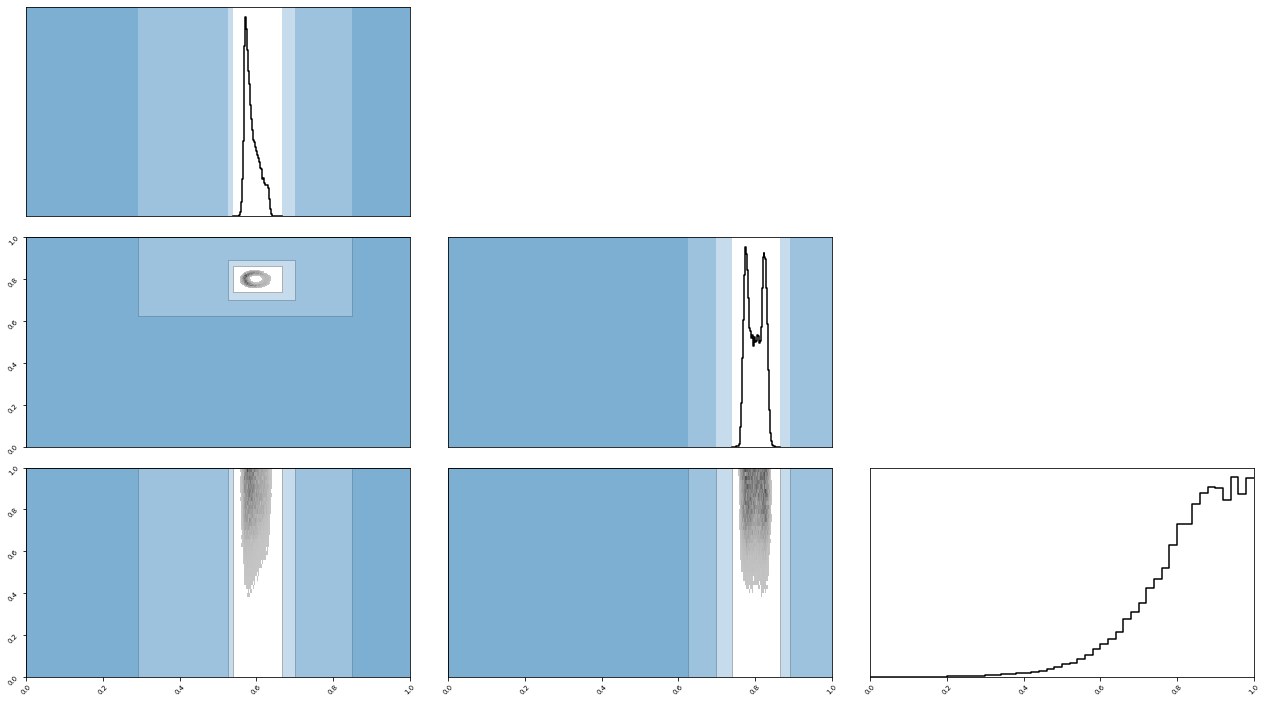

In [17]:
import swyft.utils.constrainedcorner as cc

fs = focused_samples[-1]
dfs = swyft.utils.get_df_dict_from_weighted_marginals(fs)

fig, axes = cc.corner(dfs, figsize=(22,12), xlim=(0, 1), ylim_lower=(0, 1))
for bound in bounds:
    cc.diagonal_constraint(axes, bound)
for bound in bounds:
    cc.lower_constraint(axes, bound)
fig.savefig("figures/torus-corner-conceptual.png", bbox_inches="tight")

Text(0.5, 0, 'n simulations')

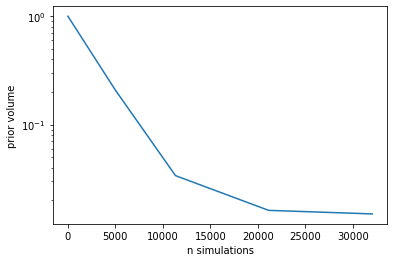

In [18]:
fig, axes = plt.subplots()
axes.plot([0] + n_simulations, volumes)
axes.set_yscale('log')
axes.set_ylabel("prior volume")
axes.set_xlabel("n simulations")
# fig.savefig("figures/volume.pdf")

In [19]:
# rounds = len(n_simulations)
# nrows = rounds -1

# fig, axes = plt.subplots(
#     nrows=nrows, 
#     ncols=3, 
#     figsize=(11, 2 * nrows), 
#     sharex='col', 
#     sharey='row'
# )

# for i, marginal in enumerate(focused_rejection_samples[:-1]):
#     for j in range(task.dim_parameters):
#         key = (j,)
#         ax = axes[i, j]
#         sns.histplot(
#             data=marginal[key].flatten(),
#             ax=ax,
#             stat='density',
#             binrange=(0.0, 1.0),
#             bins=150
#         )
# #         sns.histplot(
# #             data=marginal['params'][:, j], 
# #             weights=marginal['params'][:, (j,)],
# #         )
# fig.savefig("figures/seaborn-zoom-1.pdf")

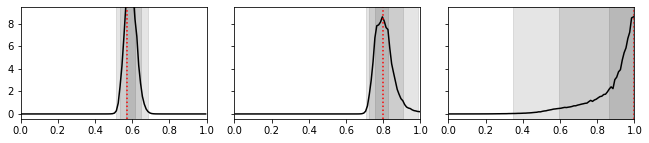

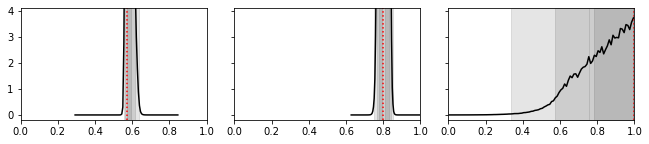

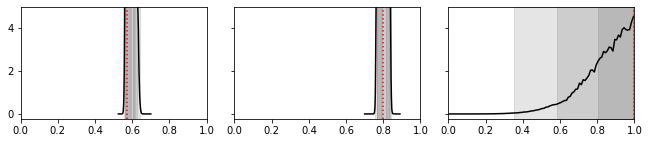

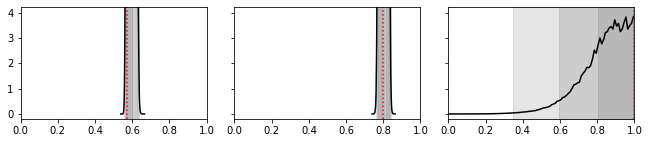

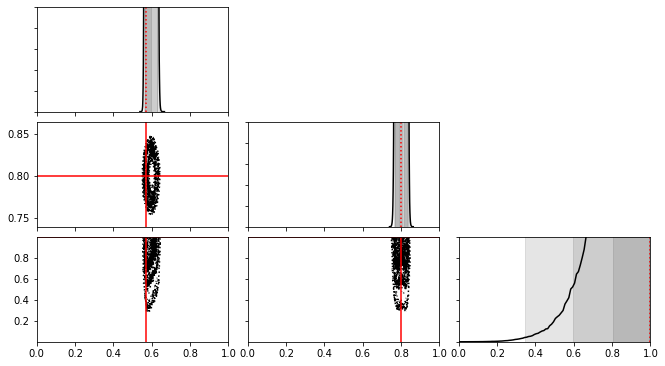

In [20]:
color = 'k'
figs1d = []
axes1d = []
for samples in focused_samples:
    fig, axes = swyft.plot1d(
        samples, 
        range(task.dim_parameters), 
        color=color,
        figsize = (11, 2), 
        truth=theta0,
        subplots_kwargs={"sharey": True}
    )
    for ax in axes.flatten():
        ax.set_xlabel("")
        ax.set_xlim(0., 1.)
#         ax.tick_params(
#             axis='y',
#             which='both',
#             left=True,
#             right=False,
#             labelleft=True,
#         )
    figs1d.append(fig)
    axes1d.append(axes)
# for i, fig in enumerate(figs1d):
#     fig.savefig(f"figures/zoomin-{i}.pdf")
    
fig_corner, axes_corner = swyft.corner(
    focused_samples[-1], 
    range(task.dim_parameters), 
    color=color, 
    figsize = (11, 6), 
    truth=theta0,
)

diag, offdiag, _ = swyft.utils.split_corner_axes(axes_corner)
for ax in offdiag:
    ax.set_ylim(0., 1.)

for ax in axes_corner.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(0., 1.)

# fig_corner.savefig(f"figures/zoomin-{i+1}-corner.pdf")

# ground truth

In [21]:
path = f"torus-ref.pickle"
if SAVE:
    reference_samples = task.get_reference_posterior_samples(NUM_OBS).numpy()
    ref_marginals = tmnre.benchmark.sbibm.load_ref_and_marginalize(task, NUM_OBS)
    with open(path, "wb") as f:
            pickle.dump((reference_samples, ref_marginals), f)
else:
    with open(path, "rb") as f:
        reference_samples, ref_marginals = pickle.load(f)

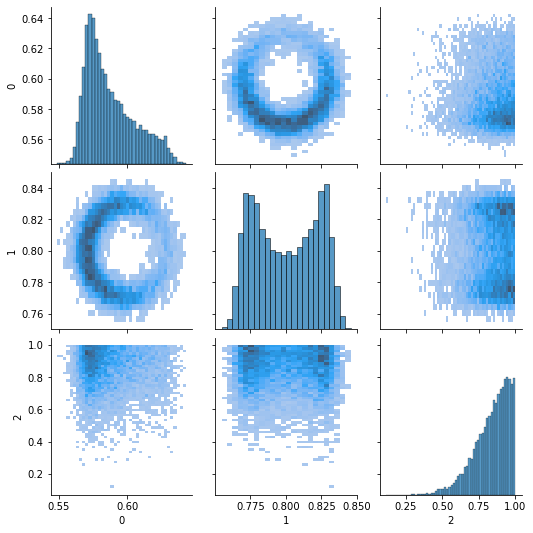

In [22]:
sns.pairplot(
    pd.DataFrame(reference_samples, columns=range(task.dim_parameters)),
    kind='hist',
)

# How do the samples look?

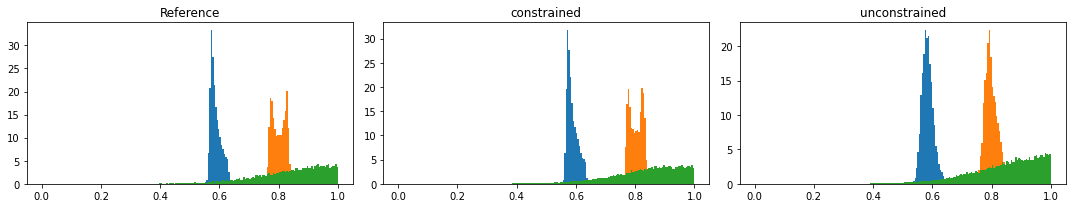

In [23]:
ref_marginals_1d = filter_marginals_by_dim(ref_marginals, 1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
kwargs = dict(
    bins = 200,
    density = True,
    range = (0, 1),
)

for key, rs1d in ref_marginals_1d.items():
    axes[0].hist(rs1d, **kwargs)

for ind in range(task.dim_parameters):
    fs = focused_samples[-1]
    us = unfocused_samples[-1]
    axes[1].hist(fs['params'][:, ind], weights=fs['weights'][(ind,)], **kwargs)
    axes[2].hist(us['params'][:, ind], weights=us['weights'][(ind,)], **kwargs)

axes[0].set_title("Reference")
axes[1].set_title("constrained")
axes[2].set_title("unconstrained")
fig.tight_layout()

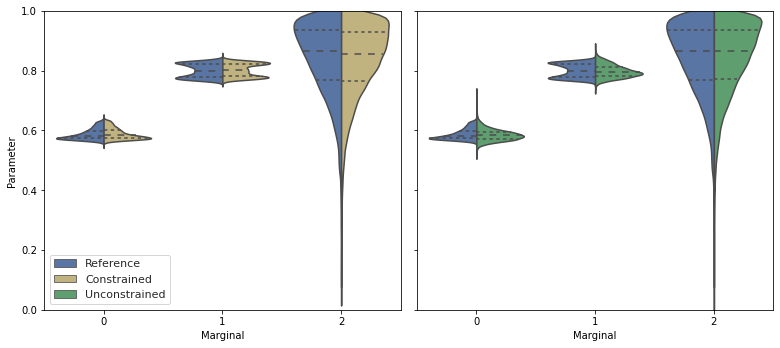

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 5), sharey=True)
constrained_name = "Constrained"
unconstrained_name = "Unconstrained"
my_pal = {"Reference": "b", constrained_name: "y", unconstrained_name: "g"}


swyft.utils.violin_plot(ref_marginals, focused_rejection_samples[-1], constrained_name, ax=axes[0], palette=my_pal)
swyft.utils.violin_plot(ref_marginals, unfocused_rejection_samples[-1], unconstrained_name, ax=axes[1], palette=my_pal)

axes[1].set_ylabel("")

for ax in axes:
    ax.legend([],[], frameon=False)
    ax.set_ylim(0., 1.)

handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()

axes[0].legend(
    [*handles1, handles2[1]], 
    [*labels1, labels2[1]], 
    loc='lower left',
#     loc=(0.07, 0.137),
)
fig.tight_layout()
fig.savefig("figures/torus-violin.pdf", bbox_inches="tight")

In [25]:
if False:
    def get_ci(samples, credibility_level=0.95450, bins=55):
        samples_dim = filter_marginals_by_dim(samples, 1)
        return [tmnre.coverage.oned.get_credible_intervals(s, bins=bins, credibility_level=credibility_level) for s in samples_dim.values()]

    def get_swyft_ci(swyft_samples, credibility_level=0.95450, bins = 55):
        p = swyft_samples['params']
        w = filter_marginals_by_dim(swyft_samples['weights'], 1)
        return [tmnre.coverage.oned.get_credible_intervals(p[:, ind], w[(ind,)], bins, credibility_level=credibility_level) for ind in range(p.shape[-1])]

    def wandelt_plot(intervals, ref_intervals, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        
        assert len(intervals) == len(ref_intervals)
        indices = np.arange(len(intervals))
        
        ax.plot(indices, [inter.flatten() for inter in intervals], 'b')

        # This is a bit fragile
        num_modes = len(ref_intervals[0][:, 0])
        for mode in range(num_modes):
            ax.fill_between(
                indices, 
                [inter[mode, 0] for inter in ref_intervals], [inter[mode, 1] for inter in ref_intervals], 
                alpha=0.5,
                color='orange',
            )
        return ax

    assert len(noisy_focused_samples) == len(focused_samples)
    ref_intervals = get_ci(ref_marginals)
    noisy_focused_intervals = [get_swyft_ci(ns) for ns in noisy_focused_samples]
    focused_intervals = [get_swyft_ci(bs) for bs in focused_samples]

    nrows = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=len(focused_intervals), figsize=(20, 5))
    print(axes.shape)
    axes = axes.reshape(nrows, len(focused_intervals))
    for i, (ni, fi) in enumerate(zip(noisy_focused_intervals, focused_intervals)):
        wandelt_plot(ni, ref_intervals, axes[0, i])
        wandelt_plot(fi, ref_intervals, axes[1, i])
        try:
            wandelt_plot(si, ref_intervals, axes[2, i])
        except ValueError:
            pass
        axes[0, i].set_title(f"Round {i}")
    axes[0, 0].set_ylabel("Fixed Noise")
    axes[1, 0].set_ylabel("Bootstrap Noise")
    axes[1, 0].set_ylabel("Reference")
    fig.tight_layout()

# kld vs budget

In [26]:
def get_summary_kld(samples, ref_samples, limits=(0.0, 1.0), bins=100, add_a_sample=True):
    task_limits = np.ones((task.dim_parameters, 2)) * limits
    doit = partial(
        tmnre.metrics.kl.kl_summary_swyft,
        ref_samples=ref_samples,
        task_limits=task_limits,
        dim=1,
        bins=bins,
        add_a_sample=add_a_sample,
    )
    return [sum(doit(swyft_samples=s).values()) for s in samples]
#     return [doit(swyft_samples=s).values() for s in samples]

focused_klds = get_summary_kld(focused_samples, reference_samples)

unfocused_samples_fixed = deepcopy(unfocused_samples)
for s in unfocused_samples_fixed:
    s['weights'] = valmap(lambda x: x + 1e-16, s['weights'])
unfocused_klds = get_summary_kld(unfocused_samples_fixed, reference_samples)

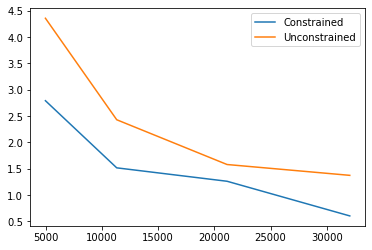

In [27]:
sns.reset_orig()
fig, ax = plt.subplots()
ax.plot(n_simulations, torch.tensor(focused_klds).numpy(), label="Constrained")
ax.plot(n_simulations, torch.tensor(unfocused_klds).numpy(), label="Unconstrained")
# ax.set_yscale("log")
ax.legend()

# c2st vs. budget

In [28]:
path = f"torus-c2sts.pickle"
if SAVE:
    focused_c2sts = [
        tmnre.metrics.c2st.c2st_on_marginals(ref_marginals, valmap(get_10k, foc_s), n_jobs=10)
        for foc_s in focused_rejection_samples
    ]
    unfocused_c2sts = [
        tmnre.metrics.c2st.c2st_on_marginals(ref_marginals, valmap(get_10k, unf_s), n_jobs=10)
        for unf_s in unfocused_rejection_samples
    ]
    with open(path, "wb") as f:
        pickle.dump((focused_c2sts, unfocused_c2sts), f)
else:
    with open(path, "rb") as f:
        focused_c2sts, unfocused_c2sts = pickle.load(f)

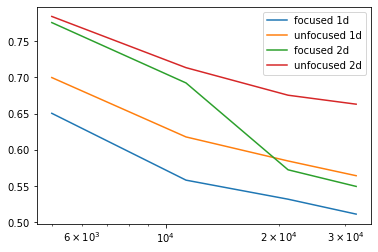

In [29]:
fig, ax = plt.subplots()
get_1d_mean = lambda x: torch.tensor([i['1-dim mean'] for i in x]).numpy()
get_2d_mean = lambda x: torch.tensor([i['2-dim mean'] for i in x]).numpy()

ax.plot(n_simulations, get_1d_mean(focused_c2sts), label="focused 1d")
ax.plot(n_simulations, get_1d_mean(unfocused_c2sts), label="unfocused 1d")
ax.plot(n_simulations, get_2d_mean(focused_c2sts), label="focused 2d")
ax.plot(n_simulations, get_2d_mean(unfocused_c2sts), label="unfocused 2d")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

# Coverage Testing

In [30]:
def get(i, k, nsamples = 3000):
    samples = micro.posteriors[-1].sample(nsamples, micro.datasets[-1][i][0])
    z0 = micro.datasets[-1][i][1].numpy()[k]
    z = samples['params'][:,k]
    w = samples['weights'][(k,)]
    w0 = interpolate.interp1d(z, w, assume_sorted = False, fill_value = "extrapolate")(z0)
    mass_total = w.sum()

    mass_contained = w[w>=w0].sum()
    f = 1-mass_contained/mass_total
    return f

0
1
2


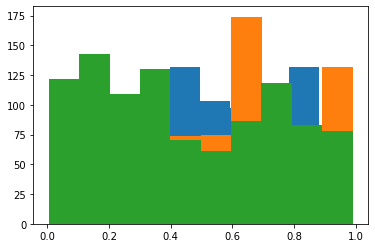

In [31]:
path = "torus-covfs.npz"
if SAVE:
    covfs = {}
    for d in range(task.dim_parameters):
        covfs[str(d)] = np.array([[get(i, d) for j in range(0, 10)] for i in range(100)])
    with open(path, "wb") as f:
        np.savez(f, **covfs)
else:
    with open(path, "rb") as f:
        covfs = np.load(path)
for d, v in covfs.items():
    print(d)
    plt.hist(v.flatten())

0.60848 0.9557499999999998


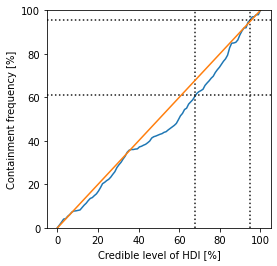

In [32]:
relevant_covfs = covfs["2"]
ccount = stats.cumfreq(1-relevant_covfs.flatten(), numbins = 100).cumcount
ccount /= ccount.max()
ccount_err = np.sqrt(ccount*ccount*(1-ccount))
plt.figure(figsize = (4, 4))
plt.plot(np.linspace(0, 100, len(ccount)), ccount*100)
#plt.plot(np.linspace(0, 100, len(ccount)), (ccount+ccount_err)*100)
plt.ylim([0, 100])
f68 = np.interp(0.68, np.linspace(0, 1, len(ccount)), ccount)
f95 = np.interp(0.95, np.linspace(0, 1, len(ccount)), ccount)
plt.axvline(68, color='k', ls=':')
plt.axvline(95, color='k', ls=':')
plt.axhline(f68*100, color='k', ls=':')
plt.axhline(f95*100, color='k', ls=':')
plt.xlabel("Credible level of HDI [%]")
plt.plot([0, 100], [0, 100])
plt.ylabel("Containment frequency [%]")
print(f68, f95)